In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf
import matplotlib.cm as cm
from scipy.stats import skew,kurtosis
color =cm.viridis
Tc = 2/np.log(1+2**0.5)

In [2]:
def lin_fit(x,a,b):
    return a + b*x

In [3]:
def radial_corr(data):
    N = data.shape[1]
    L = int(N**0.5)
    rsq = np.array([])
    gr = np.array([])
    covmat = np.cov(data.T)
    for i in range(N):
        ix = i%L
        iy = np.floor(i/L).astype(np.int32)
        for j in range(i,N):
            jx = j%L
            jy = np.floor(j/L).astype(np.int32)
            rsq = np.append(rsq, (ix-jx)**2 + (iy-jy)**2)
            gr = np.append(gr,covmat[i][j])
    ord = np.argsort(rsq)
    ordgr = gr[ord]
    ordrsq = rsq[ord]
    dist, dist_c = np.unique(np.sqrt(rsq), return_counts=True)
    start = 0
    gr = np.array([])
    for i in range(len(dist_c)):
        end = start + dist_c[i]-1
        gr = np.append(gr,np.mean(ordgr[start:end]))
        start = end +1
    table = dist < (L+1)/2
    return dist[table],gr[table]

In [4]:
def load_data(L,diffTemp,P,temp,nSteps,dt,last = False):
    if last:
        return np.load(f"x_recon_L{L}/x_recon_L{L}_T{temp:.3f}_difftemp{diffTemp:.3f}.npy")
    else:
        return np.load(f"x_recon_L{L}_traj/x_recon_L{L}_T{temp:.3f}_difftemp{diffTemp:.3f}.npy")
    
def load_data_lin(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")[:,0,:]
    else:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
    
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [150]:
Ls = np.array([8,10,12,14])
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
diffTemp = 2
nSteps = 300
dt = 0.02
P = 100000

Let's look at the radial correlation, for different cases.
Pure, linear score, non linear score

In [151]:
lidx = 0
tidx = 11
original = load_original_data(Ls[lidx],Ts[tidx],200000)
lin = load_data_lin(Ls[lidx]**2,2,100000,Ts[tidx],nSteps,dt,False)
nonlin = load_data(Ls[lidx],diffTemp,100000,Ts[tidx],nSteps,dt,False)
covmat_or = np.cov(original.T)
covmat_lin = np.cov(lin.T)
covmat_nonlin = np.cov(nonlin.T)

ValueError: m has more than 2 dimensions

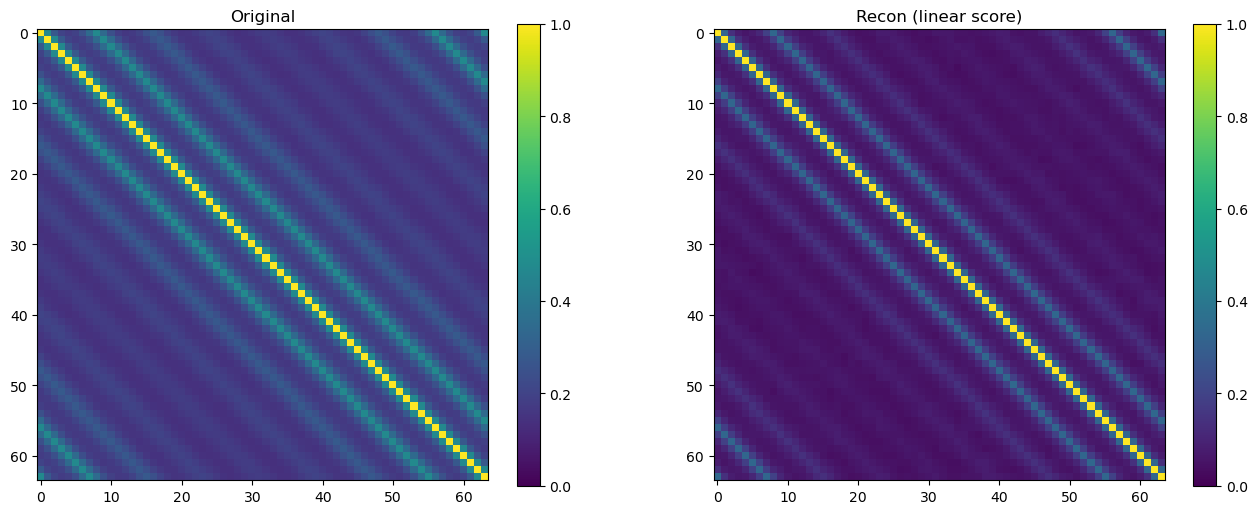

In [152]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(np.cov(original.T),norm= norm)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Recon (linear score)")
plt.imshow(np.cov(lin.T),norm= norm)
plt.colorbar()
plt.savefig("corrmat_comp.png")

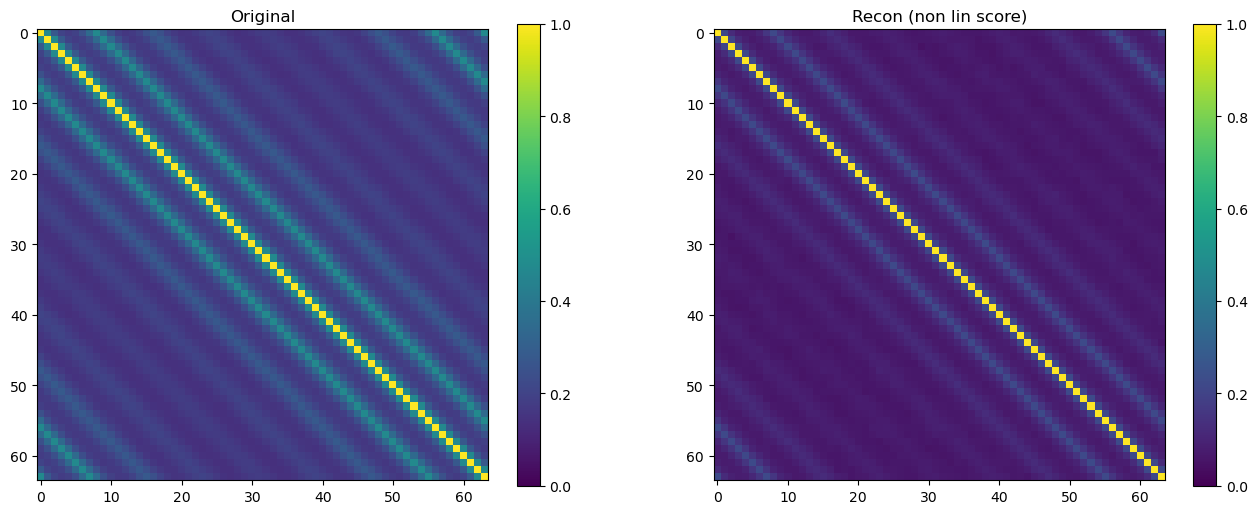

In [66]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(np.cov(original.T),norm= norm)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Recon (non lin score)")
plt.imshow(np.cov(np.sign(nonlin.T)),norm= norm)
plt.colorbar()
plt.savefig("corrmat_comp.png")

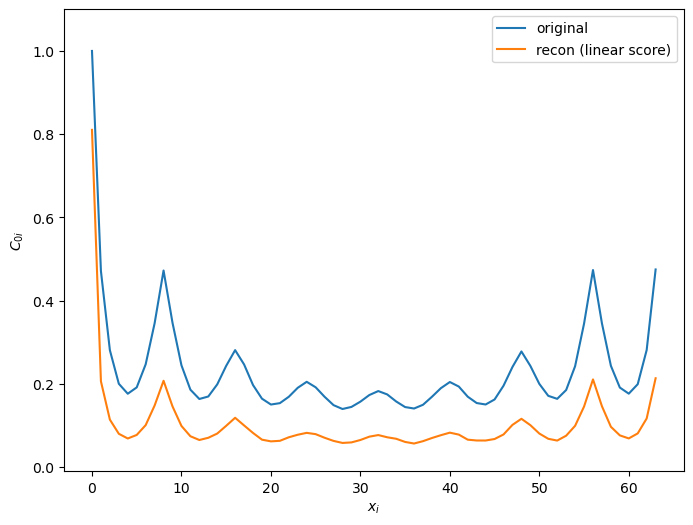

In [67]:
plt.figure(figsize = (8.,6))
plt.plot([*range(Ls[0]**2)],covmat_or[0,:],label = "original")
plt.plot([*range(Ls[0]**2)],covmat_nonlin[0,:],label = "recon (linear score)")
plt.xlabel(r"$x_i$")
plt.ylabel(r"$C_{0i}$")
plt.ylim([-0.01,1.1])
plt.legend()
plt.savefig("corrmat_comp_0i.png")

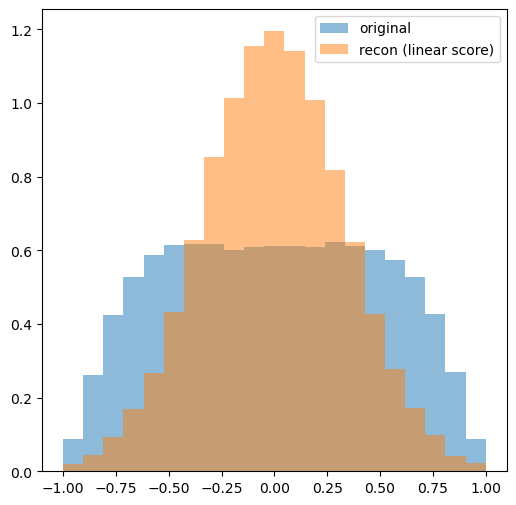

In [68]:
magn_or = np.mean(original,axis = 1)
magn_lin = np.mean(lin,axis = 1)
plt.figure(figsize =  (6,6))
plt.hist(magn_or,bins = 21,range=(-1,1),density=True,alpha = 0.5,label = "original")
plt.hist(magn_lin,bins = 21,range=(-1,1),density=True,alpha = 0.5,label = "recon (linear score)")
plt.legend()
plt.savefig("pdf_m_thigh.png")

-0.48252504464577184

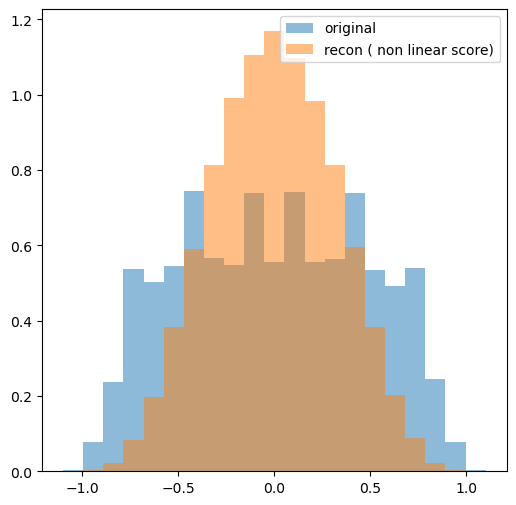

In [69]:
magn_nonlin = np.mean(nonlin,axis = 1)
plt.figure(figsize =  (6,6))
plt.hist(magn_or,bins = 21,range=(-1.1,1.1),density=True,alpha = 0.5,label = "original")
plt.hist(magn_nonlin,bins = 21,range=(-1.1,1.1),density=True,alpha = 0.5,label = "recon ( non linear score)")
plt.legend()
plt.savefig("pdf_m_tlow_nonlin.png")
kurtosis(magn_nonlin)


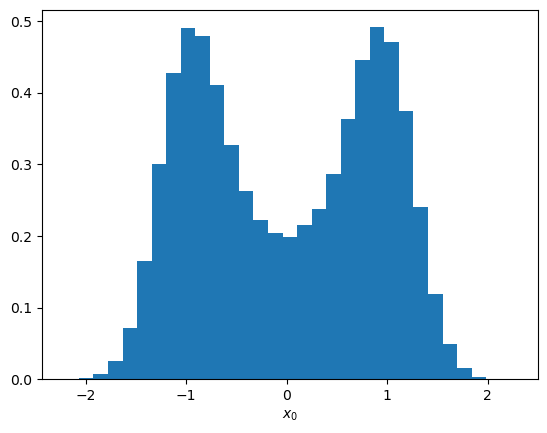

In [70]:
plt.hist(nonlin[:,0],bins = 31,density = "True")
plt.xlabel(r"$x_0$")
plt.savefig("px_0.png")

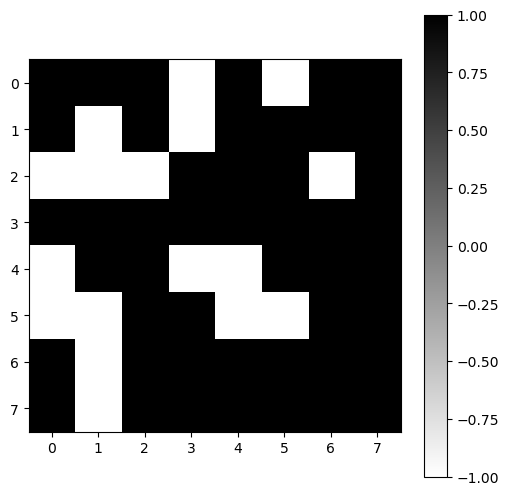

In [77]:
plt.figure(figsize = (6,6))
plt.imshow(np.sign(nonlin[10000]).reshape(8,8),cmap = "binary")
plt.colorbar()


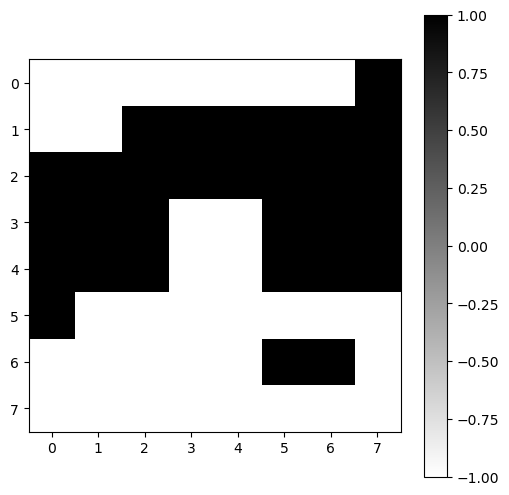

In [78]:
plt.figure(figsize = (6,6))
plt.imshow(original[100].reshape(8,8),cmap = "binary")
plt.colorbar()

In [ ]:
magn_or = np.mean(original,axis = 1)
magn_lin = np.mean(lin,axis = 1)
plt.figure(figsize =  (6,6))
plt.hist(magn_or,bins = 21,range=(-1,1),density=True,alpha = 0.5,label = "original")
plt.hist(magn_lin,bins = 21,range=(-1,1),density=True,alpha = 0.5,label = "recon (linear score)")
plt.legend()
plt.savefig("pdf_m_tc.png")

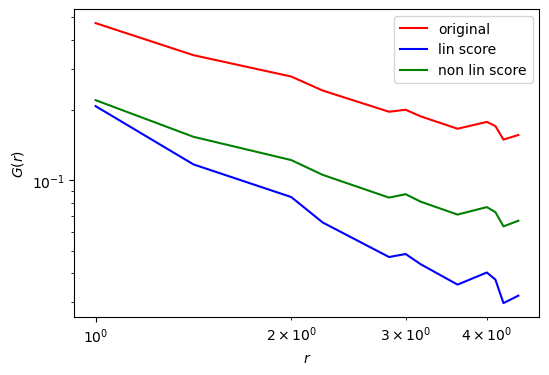

In [135]:
plt.figure(figsize= (6,4))
lidx = 0
tidx = 11
original = load_original_data(Ls[lidx],Ts[tidx],200000)
lin = load_data_lin(Ls[lidx]**2,diffTemp,100000,Ts[tidx],nSteps,dt,False)
nonlin = load_data(Ls[lidx],diffTemp,100000,Ts[tidx],nSteps,dt,False)

dist, gr_or = radial_corr(original)
table = dist>0
plt.plot(dist[table],gr_or[table],color = "red", label = "original")
dist, gr_lin = radial_corr(np.sign(lin))
table = dist>0
plt.plot(dist[table],gr_lin[table],color = "blue", label = "lin score")
dist, gr_nonlin = radial_corr(np.sign(nonlin))
table = dist>0
plt.plot(dist[table],gr_nonlin[table],color = "green", label = "non lin score")
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$G(r)$")
plt.legend()
plt.savefig("gofr_comp.png")

In [79]:
susc_true = np.zeros((len(Ls),len(Ts)))
susc_recon = np.zeros((len(Ls),len(Ts)))
for l,L in enumerate(Ls):
    N = L**2
    for t,T in enumerate(Ts):
        data = load_data(L,diffTemp,P,T,nSteps,dt)
        magn = np.mean(data,axis = 1)
        susc_recon[l][t] = L**2*(np.mean(magn**2) - 0*np.mean(magn)**2)/T
        data = load_original_data(L,T,200000)
        magn = np.mean(data,axis = 1)
        susc_true[l][t] = L**2*(np.mean(magn**2) - 0*np.mean(magn)**2)/T
        del data

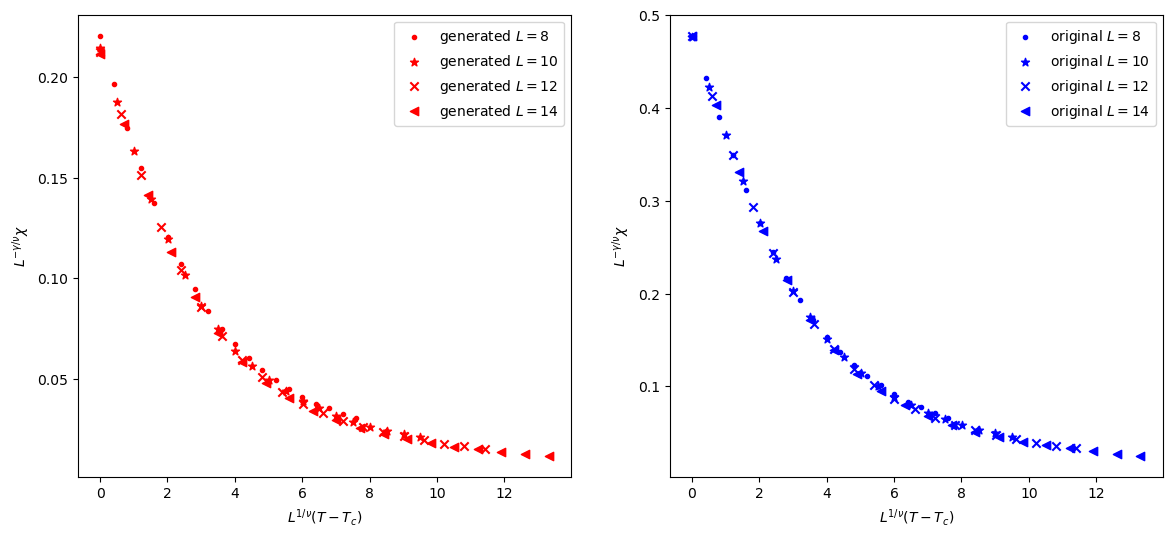

In [81]:

plt.figure(figsize = (14,6))
mks = [".","*","x","<"]
for l,L in enumerate(Ls):
    plt.subplot(1,2,1)
    plt.scatter(L*(Ts-Tc),susc_recon[l]*L**(-7/4),color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    #plt.scatter(Ts,susc_recon[l],color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(L*(Ts-Tc),susc_true[l]*L**(-7/4),color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    #plt.scatter(Ts,susc_true[l],color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
plt.savefig("susc_nonlin.png")

In [15]:
def getBinder(data):
    return 1-np.mean(data**4)/(3*np.mean(data**2)**2)

In [16]:
binder_true = np.zeros((len(Ls),len(Ts)))
binder_recon = np.zeros((len(Ls),len(Ts)))
for l,L in enumerate(Ls):
    N = L**2
    for t,T in enumerate(Ts):
        data = load_data(L,diffTemp,P,T,nSteps,dt)
        magn = np.mean(np.sign(data),axis = 1)
        binder_recon[l][t] = getBinder(magn)
        data = load_original_data(L,T,200000)
        magn = np.mean(data,axis = 1)
        binder_true[l][t] = getBinder(magn)
        del data

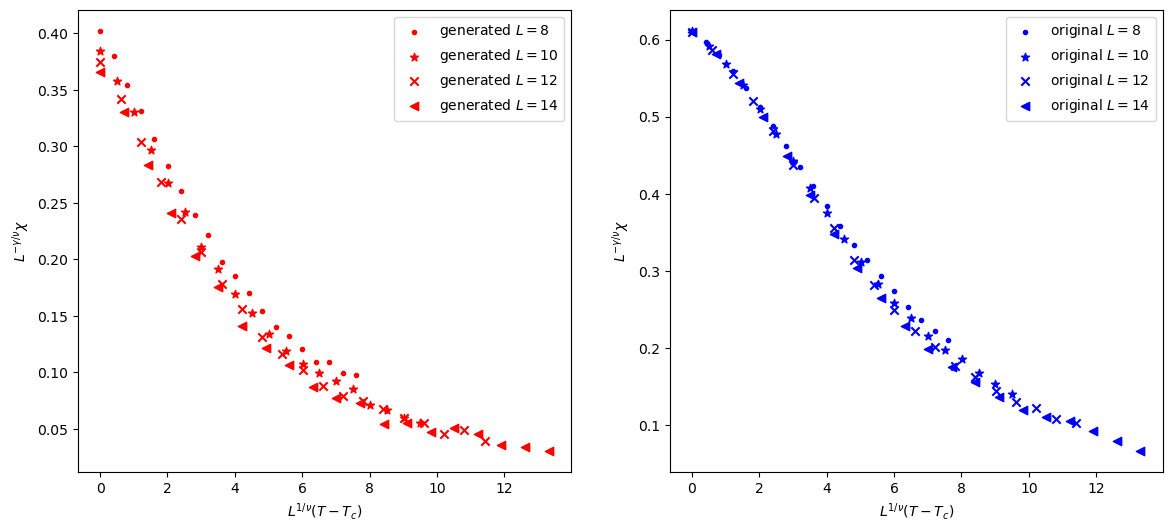

In [17]:
Tc = 2/np.log(1+2**0.5)
plt.figure(figsize = (14,6))
mks = [".","*","x","<"]
for l,L in enumerate(Ls):
    plt.subplot(1,2,1)
    plt.scatter(L*(Ts-Tc),binder_recon[l],color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(L*(Ts-Tc),binder_true[l],color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()


In [126]:
trajdata = load_data(Ls[3],0.1,P,2.32,nSteps,dt)
slices = np.linspace(1,1+nSteps,trajdata.shape[1])
trajdata.shape

(100000, 9, 196)

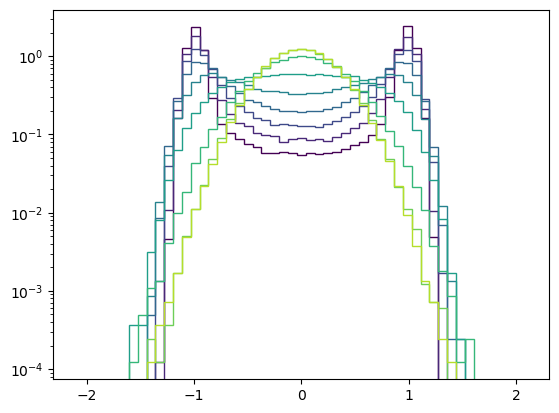

In [158]:
for i in range(9):
    plt.hist(trajdata[:,i,0],density=True,range = (-2.1,2.1),alpha = 1,bins = 51,histtype = "step",color = color(i/9))
plt.yscale("log")

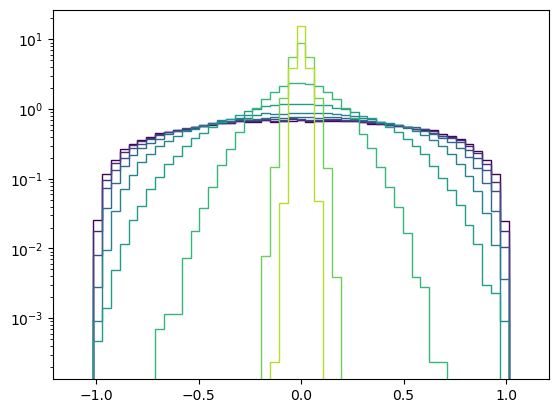

In [159]:
trajmagn = np.mean(trajdata,axis = -1)
for i in range(9):
    plt.hist(trajmagn[:,i],density=True,range = (-1.1,1.1),alpha = 1,bins = 51,histtype = "step",color = color(i/9))
plt.yscale("log")

In [134]:
mthresh = 0.2
zeromagntab = np.abs(trajmagn[:,0]) < mthresh
zeromagntab.shape

(100000,)

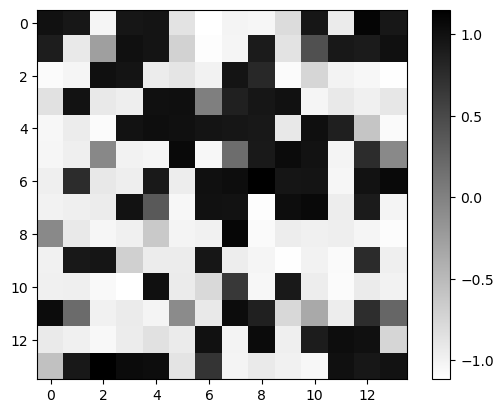

In [135]:
plt.imshow(trajdata[zeromagntab][0,0].reshape(Ls[3],Ls[3]),cmap = "binary")
plt.colorbar()

(array([90.,  9.,  4.,  1.,  2.,  2.,  4.,  3., 33., 48.]),
 array([-1.08598244, -0.85994339, -0.6339044 , -0.40786535, -0.18182632,
         0.0442127 ,  0.27025172,  0.49629074,  0.7223298 ,  0.94836879,
         1.17440784]),
 <BarContainer object of 10 artists>)

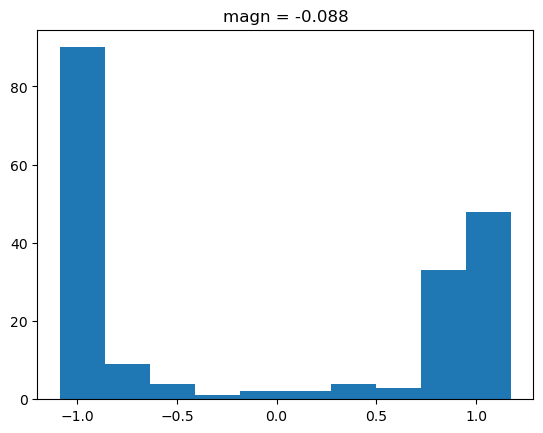

In [136]:
k = 3
plt.title(f"magn = {trajmagn[zeromagntab][k,0]:.3f}")
plt.hist(trajdata[zeromagntab][k,0])

66554

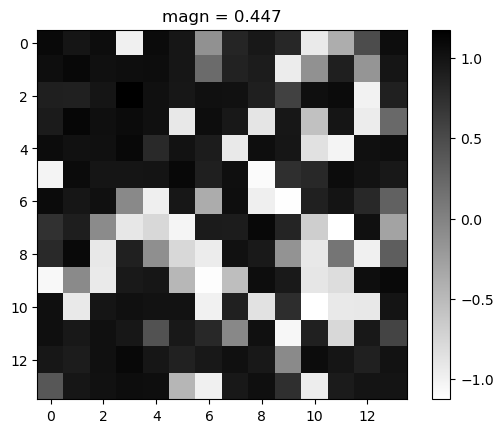

In [155]:
nonzeromagntab = np.abs(trajmagn[:,0])>0.25
plt.title(f"magn = {trajmagn[nonzeromagntab][k,0]:.3f}")
plt.imshow(trajdata[nonzeromagntab][k,0].reshape(Ls[3],Ls[3]),cmap = "binary")
plt.colorbar()
np.sum(nonzeromagntab)

(array([32.,  8.,  4.,  3., 10.,  3.,  4.,  3., 36., 93.]),
 array([-1.12543142, -0.89526045, -0.66508949, -0.43491849, -0.20474751,
         0.02542347,  0.25559443,  0.48576543,  0.71593642,  0.94610739,
         1.17627835]),
 <BarContainer object of 10 artists>)

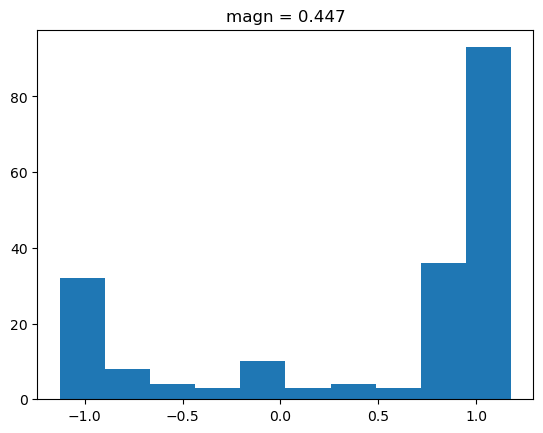

In [156]:
plt.title(f"magn = {trajmagn[nonzeromagntab][k,0]:.3f}")
plt.hist(trajdata[nonzeromagntab][k,0])

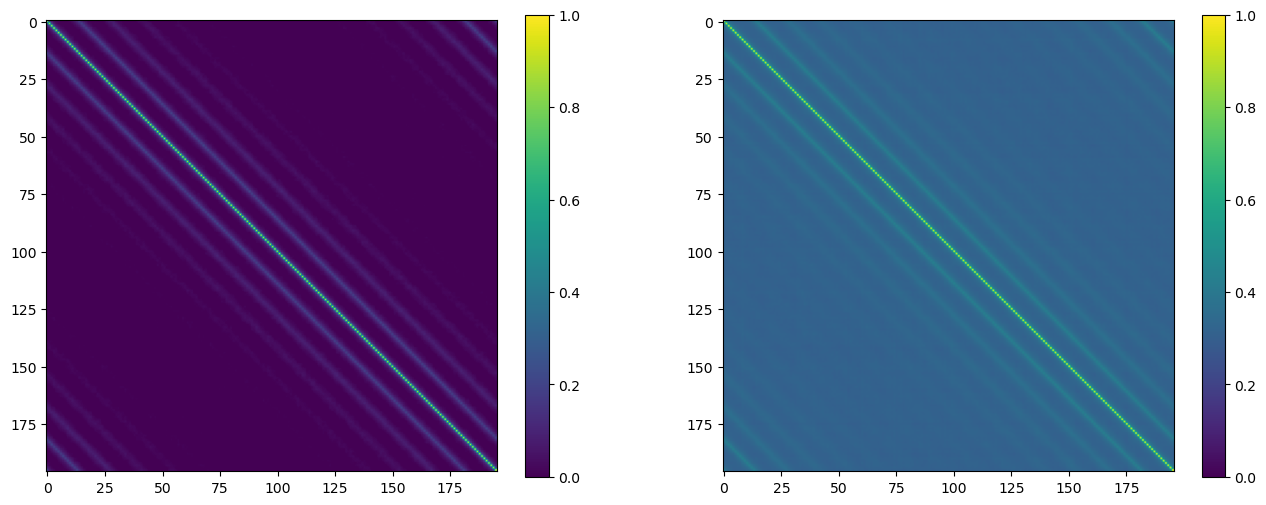

In [157]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.imshow(np.cov(trajdata[zeromagntab][:,0].T),norm = norm)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.cov(trajdata[nonzeromagntab][:,0].T),norm = norm)
plt.colorbar()